## Assignment 3: $k$ Nearest Neighbor


**Q1.**
1. What is the difference between regression and classification?
2. What is a confusion table? What does it help us understand about a model's performance?
3. What does the SSE quantify about a particular model?
4. What are overfitting and underfitting?
5. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or SSE on the test set, improve model performance?
6. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.

1. Regression predicts a continuous numeric value, while classification predicts a categorical class label.

2. A confusion table compares predicted vs. actual class labels and shows where the model is correct or makes specific types of errors

3. SSE measures the total squared difference between predicted and actual values, capturing how far off the model’s predictions are overall.

4. Overfitting occurs when a model fits the training data too closely and performs poorly on new data, while underfitting occurs when a model is too simple to capture the underlying pattern.

5. It helps ensure the model generalizes well by selecting a value of
𝑘 that performs best on unseen data, rather than just memorizing the training set.

6. Class labels are simple and easy to interpret, but probabilities provide more information about uncertainty and confidence at the cost of added complexity.

**Q2.** This question is a case study for $k$ nearest neighbor regression, using the `USA_cars_datasets.csv` data.

The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for evaluation.
4. Use the $k$NN algorithm and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the mean squared error and print a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Q2: kNN regression case study (price ~ year + mileage)



df = pd.read_csv("/content/USA_cars_datasets.csv")


df = df[["price", "year", "mileage"]].copy()

na_counts = df.isna().sum()
# print(na_counts)
df = df.dropna()

# head + dimensions
print("Head:")
print(df.head())
print("\nDimensions (rows, cols):", df.shape)
print("\nNA counts after dropna:")
print(df.isna().sum())

# --- maxmin normalize year + mileage ---
# max-min normalize: (x - min) / (max - min)
for col in ["year", "mileage"]:
    mn = df[col].min()
    mx = df[col].max()
    df[col] = (df[col] - mn) / (mx - mn)

# --- split 80/20 train/test ---
X = df[["year", "mileage"]].values
y = df["price"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# --- run kNN for the requested k values, compute MSE, and plot predicted vs actual ---
ks = [3, 10, 25, 50, 100, 300]
mse_results = {}

for k in ks:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_results[k] = mse

    print(f"k={k:>3} | MSE = {mse:,.2f}")

    # scatterplot: actual (test) vs predicted
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.title(f"Actual vs Predicted Price (k={k})")
    plt.xlabel("Actual price (test)")
    plt.ylabel("Predicted price")
    plt.show()

    # patterns as k increases (general idea):
    # - small k (like 3) usually tracks the data more closely, can get kinda noisy (overfit vibes)
    # - big k (like 300) averages a ton of neighbors, predictions get smoothed out / pulled toward the mean (underfit vibes)

# --- determine optimal k (lowest MSE) ---
best_k = min(mse_results, key=mse_results.get)
print("\nBest k (min test MSE):", best_k)
print("Best MSE:", mse_results[best_k])

# --- part 6/7 answers ---
# What happened in the plots as k varied:
# - with low k, predictions are more spread out / “react” a lot to local points -> can look closer to actual values
#   but also can be jumpy/noisy -> that's overfitting (fits training quirks more)
# - as k gets bigger, predictions start collapsing toward a smoother middle band -> less variance but more bias
#   so the cloud looks more compressed and misses extremes -> that's underfitting (too smoothed out)
# Using part 6: optimal k is the one with the smallest test MSE above (best generalization on unseen data)


**Q3.** This is a case study on $k$ nearest neighbor classification, using the `animals.csv` data.

The data consist of a label, `class`, taking integer values 1 to 7, the name of the species, `animal`, and 16 characteristics of the animal, including `hair`, `feathers`, `milk`, `eggs`, `airborne`, and so on.

1. Load the data. For each of the seven class labels, print the values in the class and get a sense of what is included in that group. Perform some other EDA: How big are the classes? How much variation is there in each of the features/covariates? Which variables do you think will best predict which class?
2. Split the data 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be, in my experience: Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Using all of the variables, build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion table for the optimal model, comparing predicted and actual class label on the test set. How accurate it is? Can you interpret why mistakes are made across groups?
5. Use only `milk`, `aquatic`, and `airborne` to train a new $k$-NN classifier. Print your confusion table. Mine does not predict all of the classes, only a subset of them. To see the underlying probabilities, use `model.predict_proba(X_test.values)` to predict probabilities rather than labels for your `X_test` test data for your fitted `model`. Are all of the classes represented? Explain your results.

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Q3 kNN classification (animals / zoo data)


df = pd.read_csv("/content/zoo.csv")

# quick peek
print(df.head())
print("\nshape:", df.shape)

# figure out which column is the class label (some files call it "class" or "type")
label_col = None
for c in ["class", "type", "class_type", "label"]:
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    raise ValueError("can't find the class label column")

# animal name column (usually "animal_name" or "animal")
name_col = None
for c in ["animal_name", "animal", "name", "species"]:
    if c in df.columns:
        name_col = c
        break

# print what's in each class label 1-7
print("\nexamples by class:")
for k in sorted(df[label_col].unique()):
    sub = df[df[label_col] == k]
    print(f"\nclass {k} | n={len(sub)}")
    if name_col:
        print(sub[name_col].head(15).to_list())
    else:
        print(sub.head(5))

# class sizes
print("\nclass sizes:")
print(df[label_col].value_counts().sort_index())

# variation in features
feat_cols = [c for c in df.columns if c not in [label_col, name_col]]
print("\nfeature variation (mean + std):")
print(df[feat_cols].agg(["mean", "std"]).T.sort_values("std", ascending=False).head(20))

# quick thought:
# stuff like milk/eggs/feathers/airborne/aquatic is probably doing most of the work
# bc those are basically defining traits for groups

# split 50/50
X = df[feat_cols]
y = df[label_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.50, random_state=42, stratify=y
)

# pick k by trying a bunch and using test accuracy (simple way)
k_grid = list(range(1, 26, 2))
accs = {}

for k in k_grid:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accs[k] = accuracy_score(y_test, pred)

best_k = max(accs, key=accs.get)
print("\nacc by k:")
for k in k_grid:
    print(k, round(accs[k], 4))
print("\nbest k:", best_k, "best acc:", round(accs[best_k], 4))

# optimal model confusion table
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=sorted(df[label_col].unique()))
print("\nconfusion matrix (all vars):")
print(cm)
print("accuracy:", round(accuracy_score(y_test, y_pred), 4))

# why mistakes happen:
# usually bc some classes share traits so neighbors end up mixed
# also if some classes are tiny, it's easy to misclassify them

# now do only milk, aquatic, airborne
small_feats = [c for c in ["milk", "aquatic", "airborne"] if c in df.columns]
if len(small_feats) != 3:
    raise ValueError("missing one of milk/aquatic/airborne in this dataset")

X2 = df[small_feats]
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.50, random_state=42, stratify=y
)

# reuse same k search idea
accs2 = {}
for k in k_grid:
    m2 = KNeighborsClassifier(n_neighbors=k)
    m2.fit(X2_train, y2_train)
    p2 = m2.predict(X2_test)
    accs2[k] = accuracy_score(y2_test, p2)

best_k2 = max(accs2, key=accs2.get)
print("\n(best k with 3 vars):", best_k2, "acc:", round(accs2[best_k2], 4))

model2 = KNeighborsClassifier(n_neighbors=best_k2)
model2.fit(X2_train, y2_train)
pred2 = model2.predict(X2_test)

cm2 = confusion_matrix(y2_test, pred2, labels=sorted(df[label_col].unique()))
print("\nconfusion matrix (milk/aquatic/airborne):")
print(cm2)
print("accuracy:", round(accuracy_score(y2_test, pred2), 4))

# probs
probs = model2.predict_proba(X2_test.values)

# which classes show up in predicted probs (sklearn keeps classes_ order)
print("\nmodel2 classes_ (prob columns):", model2.classes_)
present = np.where(probs.mean(axis=0) > 0)[0]
print("classes with nonzero avg prob:", model2.classes_[present])

# if it doesn't predict all classes:
# makes sense bc 3 variables can't separate 7 groups well
# so some classes just look too similar in that tiny feature space and get ignored

     animal  hair  feathers  eggs  milk  airborne  aquatic  predator  toothed  \
0  aardvark     1         0     0     1         0        0         1        1   
1  antelope     1         0     0     1         0        0         0        1   
2      bass     0         0     1     0         0        1         1        1   
3      bear     1         0     0     1         0        0         1        1   
4      boar     1         0     0     1         0        0         1        1   

   backbone  breathes  venomous  fins  legs  tail  domestic  catsize  class  
0         1         1         0     0     4     0         0        1      1  
1         1         1         0     0     4     1         0        1      1  
2         1         0         0     1     0     1         0        0      4  
3         1         1         0     0     4     0         0        1      1  
4         1         1         0     0     4     1         0        1      1  

shape: (101, 18)

examples by class:

class 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Head:
   price  year  mileage
0   6300  2008   274117
1   2899  2011   190552
2   5350  2018    39590
3  25000  2014    64146
4  27700  2018     6654

Dimensions (rows, cols): (2499, 3)

NA counts after dropna:
price      0
year       0
mileage    0
dtype: int64
k=  3 | MSE = 148,065,935.52


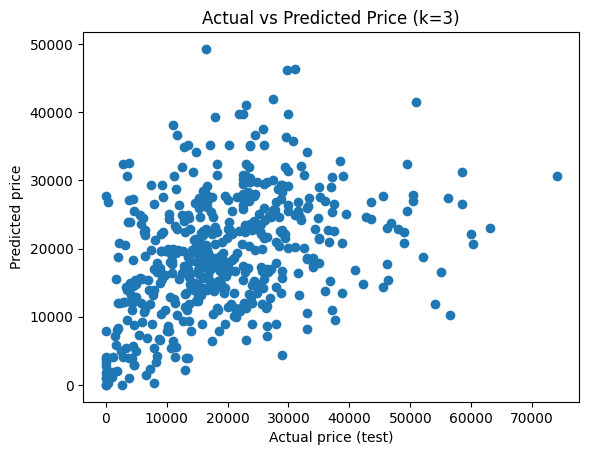

k= 10 | MSE = 117,399,126.11


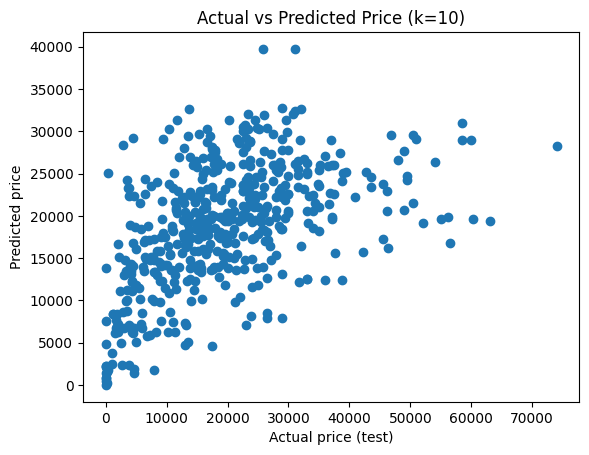

k= 25 | MSE = 112,576,160.82


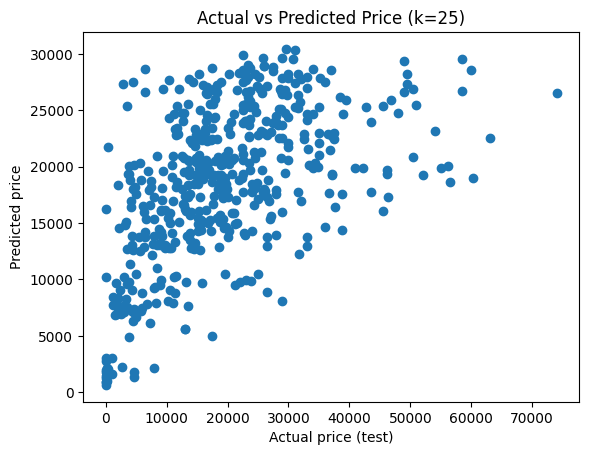

k= 50 | MSE = 110,202,549.30


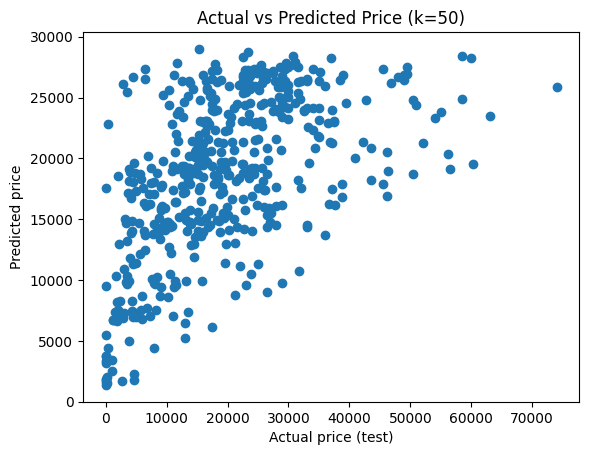

k=100 | MSE = 112,253,932.82


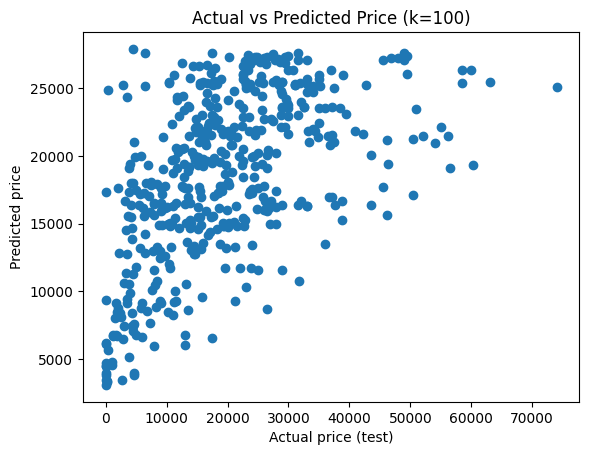

k=300 | MSE = 114,496,301.83


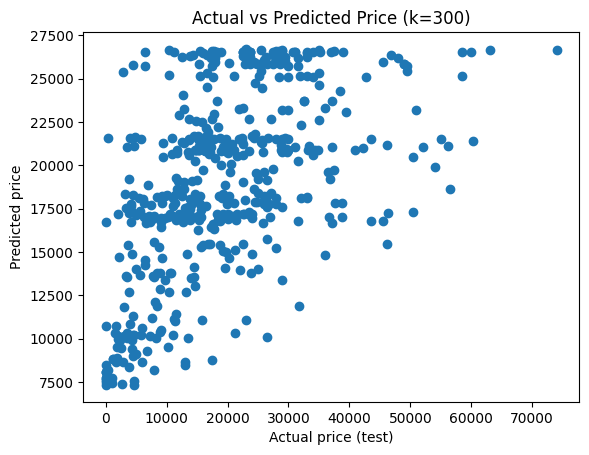


Best k (min test MSE): 50
Best MSE: 110202549.3014296


**Q4.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use a data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform
$$
k(z) = \begin{cases}
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is
$$
k(z) = \begin{cases}
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.